# Frequentism and Bayesianism: A Practical Introduction
Taken from http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/

## Part 1 of 5
## Frequentism vs. Bayesianism: a Philosophical Debate

For frequentists, probability only has meaning in terms of a **limiting case of repeated measurements.** That is, if I measure the photon flux $F$ from a given star (we'll assume for now that the star's flux does not vary with time), then measure it again, then again, and so on, each time I will get a slightly different answer due to the statistical error of my measuring device. In the limit of a large number of measurements, the frequency of any given value indicates the probability of measuring that value. For frequentists **probabilities are fundamentally related to frequencies of events.** This means, for example, that in a strict frequentist view, it is meaningless to talk about the probability of the true flux of the star: the true flux is (by definition) a single fixed value, and to talk about a frequency distribution for a fixed value is nonsense.

For Bayesians, the concept of probability is extended to cover **degrees of certainty about statements**. Say a Bayesian claims to measure the flux $F$ of a star with some probability $P(F)$: that probability can certainly be estimated from frequencies in the limit of a large number of repeated experiments, but this is not fundamental. The probability is a statement of my knowledge of what the measurement reasult will be. For Bayesians, **probabilities are fundamentally related to our own knowledge about an event.** This means, for example, that in a Bayesian view, we can meaningfully talk about the probability that the true flux of a star lies in a given range. That probability codifies our knowledge of the value based on prior information and/or available data.

The surprising thing is that this arguably subtle difference in philosophy leads, in practice, to **vastly different approaches to the statistical analysis of data.** Below I will give a few practical examples of the differences in approach, along with associated Python code to demonstrate the practical aspects of the resulting methods.

## An example: Counting Photons.
Imagine that we point our telescope to the sky, and observe the light coming from a single star. For the time being, we'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $F_{\text{true}}$ (we'll also ignore effects like sky noise and other sources of systematic error). We'll assume that we perform a series of $N$ measurements with our telescope, where the $i^{th}$ measurement reports the observed photon flux $F_i$ and error $e_{i}$.

The question is, given this set of measurements $D=\{F_i,e_i\}$, what is our best estimate of the true flux  $F_{\text{true}}$?

In [ ]:
import numpy as np
from scipy import stats

In [ ]:
np.random.seed(1)
F_true = 1000 # true flux
N = 50 # N number of measurements
F = stats.poisson(F_true).rvs(size=N)
# F = stats.poisson(F_true).rvs(size=N)
e = np.sqrt(F)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
fix, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux");
ax.set_ylabel("measurement number")

So we have our measurements.  Let's look at the Frequentist and Baysian approaches to solving this.

## Frequentist Approach to Simple Photon Counts

We'll start with the classical frequentist maximum likelihood approach. Given a single observation $D_i=(F_i,e_i)$, we can compute the probability distribution of the measurement given the true flux $F_{true}$ given our assumption of Gaussian errors:

$$ P\left(D_i | F_{true}\right)  = \frac{1}{\sqrt {2\pi e^{2}_{i}}}\text{exp} \left[ \frac{-(F_i - F_{true})^2}{2e^{2}_{i}} \right]$$

This reads as "the probability of $D_i$ given $F_{true}$ equals..." and it's recognizable as a normal distribution with mean $F_{true}$ and standard deviation $e_i$

We make the **Likelihood Function** by computing the product of the probabilities for each data point:

$$\mathcal{L}(D~|~F_{\rm true}) = \prod_{i=1}^N P(D_i~|~F_{\rm true})$$

Here $D = \{D_i\}$ represents the entire set of measurements. Because the value of the likelihood can become very small, it is often more convenient to instead compute the log-likelihood.  Combining the previous two equations and computing the log, we have

$$\log\mathcal{L} = -\frac{1}{2} \sum_{i=1}^N \left[ \log(2\pi  e_i^2) + \frac{(F_i - F_{\rm true})^2}{e_i^2} \right]$$

We'd like to know $F_{\rm true}$ such that the likelihood is maximized.  the maximization can be computed analytically (i.e. by setting $d\log\mathcal{L}/dF_{\rm true} = 0$). This results in the following observed estimate of $F_{\rm true}$:

$$ F_{\rm est} = \frac{\sum w_i F_i}{\sum w_i};~~w_i = 1/e_i^2 $$

Notice that in the special case of all errors $e_i$ being equal, this reduces to

$$ F_{\rm est} = \frac{1}{N}\sum_{i=1}^N F_i $$

That is, in agreement with intuition, $F_{\rm est}$ is simply the mean of the observed data when errors are equal.

We can go further and ask what the error of our estimate is. In the frequentist approach, this can be accomplished by fitting a Gaussian approximation to the likelihood curve at maximum; in this simple case this can also be solved analytically. It can be shown that the standard deviation of this Gaussian approximation is:

$$ \sigma_{\rm est} = \left(\sum_{i=1}^N w_i \right)^{-1/2} $$

These results are fairly simple calculations; let's evaluate them for our toy dataset:

In [ ]:
w = 1. / e ** 2
print("""
      F_true = {0}
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true, (w * F).sum() / w.sum(), w.sum() ** -0.5, N))

We find that for 50 measurements of the flux, our estimate has an error of about 0.4% and is consistent with the input value.

## Bayesian Approach to Simple Photon Counts

The Bayesian approach, as you might expect, begins and ends with probabilities.  It recognizes that what we fundamentally want to compute is our knowledge of the parameters in question, i.e. in this case,

$$ P(F_{\rm true}~|~D) $$

Note that this formulation of the problem is *fundamentally contrary* to the frequentist philosophy, which says that *probabilities have no meaning for model parameters* like $F_{\rm true}$. Nevertheless, within the Bayesian philosophy this is perfectly acceptable. 

To compute this result, Bayesians next apply [Bayes' Theorem](http://en.wikipedia.org/wiki/Bayes\'_theorem), a fundamental law of probability:

$$ P(F_{\rm true}~|~D) = \frac{P(D~|~F_{\rm true})~P(F_{\rm true})}{P(D)} $$

Though Bayes' theorem is where Bayesians get their name, it is not this law itself that is controversial, but the Bayesian *interpretation of probability* implied by the term $P(F_{\rm true}~|~D)$.

Let's take a look at each of the terms in this expression:

- $P(F_{\rm true}~|~D)$: The **posterior**, or the probability of the model parameters given the data: this is the result we want to compute.
- $P(D~|~F_{\rm true})$: The **likelihood**, which is proportional to the $\mathcal{L}(D~|~F_{\rm true})$ in the frequentist approach, above.
- $P(F_{\rm true})$: The **model prior**, which encodes what we knew about the model prior to the application of the data $D$.
- $P(D)$: The **data probability**, which in practice amounts to simply a normalization term.

If we set the prior $P(F_{\rm true}) \propto 1$ (a *flat prior*), we find

$$P(F_{\rm true}|D) \propto \mathcal{L}(D|F_{\rm true})$$

and the Bayesian probability is maximized at precisely the same value as the frequentist result! So despite the philosophical differences, we see that (for this simple problem at least) the Bayesian and frequentist point estimates are equivalent.

### But What About the Prior?

You'll noticed that I glossed over something here: the prior, $P(F_{\rm true})$. The prior allows inclusion of other information into the computation, which becomes very useful in cases where multiple measurement strategies are being combined to constrain a single model (as is the case in, e.g. cosmological parameter estimation). The necessity to specify a prior, however, is one of the more controversial pieces of Bayesian analysis.

A frequentist will point out that the prior is problematic when no true prior information is available. Though it might seem straightforward to use a **noninformative prior** like the flat prior mentioned above, there are some [surprisingly subtleties](http://normaldeviate.wordpress.com/2013/07/13/lost-causes-in-statistics-ii-noninformative-priors/comment-page-1/) involved. It turns out that in many situations, a truly noninformative prior does not exist! Frequentists point out that the subjective choice of a prior which necessarily biases your result has no place in statistical data analysis.

A Bayesian would counter that frequentism doesn't solve this problem, but simply skirts the question. Frequentism can often be viewed as simply a special case of the Bayesian approach for some (implicit) choice of the prior: a Bayesian would say that it's better to make this implicit choice explicit, even if the choice might include some subjectivity.

### Photon Counts: the Bayesian approach

Leaving these philosophical debates aside for the time being, let's address how Bayesian results are generally computed in practice. For a one parameter problem like the one considered here, it's as simple as computing the posterior probability $P(F_{\rm true}~|~D)$ as a function of $F_{\rm true}$: this is the distribution reflecting our knowledge of the parameter $F_{\rm true}$. But as the dimension of the model grows, this direct approach becomes increasingly intractable. For this reason, Bayesian calculations often depend on sampling methods such as [Markov Chain Monte Carlo (MCMC)](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).

I won't go into the details of the theory of MCMC here. Instead I'll show a practical example of applying an MCMC approach using Dan Foreman-Mackey's excellent [emcee](http://dan.iel.fm/emcee/current/)  package.  Keep in mind here that the goal is to *generate a set of points drawn from the posterior probability distribution*, and to use those points to determine the answer we seek.

To perform this MCMC, we start by defining Python functions for the prior $P(F_{\rm true})$, the likelihood $P(D~|~F_{\rm true})$, and the posterior $P(F_{\rm true}~|~D)$, noting that none of these need be properly normalized. Our model here is one-dimensional, but to handle multi-dimensional models we'll define the model in terms of an array of parameters $\theta$, which in this case is $\theta = [F_{\rm true}]$:

In [ ]:
# Define important functions:
def log_prior(theta):
    return 1  # flat prior

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (F - theta[0]) ** 2 / e ** 2)

    # $$-0.5 \sum_{i=1}^N ( \log(2\pi  e_i^2) + \frac{(F_i - F_{\rm true})^2}{e_i^2} ) $$

def log_posterior(theta, F, e):
    # I'm really not clear on this.  The posterior is the log prior + log likelihood? when did we go over that...
    return log_prior(theta) + log_likelihood(theta, F, e) 

Now we set up the problem, including generating some random starting guesses for the multiple chains of points.

In [ ]:
# what kind of randomoness?
np.random.rand?
# doesn't say.  I guess it's not that serious.

In [ ]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers

# burn in refers to how many draws to drop at the start of the chain. this is
# because the first guess is probably bad, so the first nburn draws aren't that useful
nburn = 1000  # "burn-in" period to let chains stabilize

# This is how many draws to skip in the chain.  Adjacent draws will likely be "autocorrelated"
# that is, they'll be pretty similar to each other, so they're not that useful. so, we skip
# a lot and keep only ever nsteps^{th} draw
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

In [ ]:
import emcee

In [ ]:
emcee.EnsembleSampler?

```
emcee.EnsembleSampler?
```

```
Init signature: emcee.EnsembleSampler(nwalkers, dim, lnpostfn, a=2.0, args=[], kwargs={}, postargs=None, threads=1, pool=None, live_dangerously=False, runtime_sortingfn=None)
```

A generalized Ensemble sampler that uses 2 ensembles for parallelization.
The ``__init__`` function will raise an ``AssertionError`` if
``k < 2 * dim`` (and you haven't set the ``live_dangerously`` parameter)
or if ``k`` is odd.

**Warning**: The :attr:`chain` member of this object has the shape:
``(nwalkers, nlinks, dim)`` where ``nlinks`` is the number of steps
taken by the chain and ``k`` is the number of walkers.  Use the
:attr:`flatchain` property to get the chain flattened to
``(nlinks, dim)``. For users of pre-1.0 versions, this shape is
different so be careful!

:param nwalkers:
    The number of Goodman & Weare "walkers".

:param dim:
    Number of dimensions in the parameter space.

:param lnpostfn:
    A function that takes a vector in the parameter space as input and
    returns the natural logarithm of the posterior probability for that
    position.

:param a: (optional)
    The proposal scale parameter. (default: ``2.0``)

:param args: (optional)
    A list of extra positional arguments for ``lnpostfn``. ``lnpostfn``
    will be called with the sequence ``lnpostfn(p, *args, **kwargs)``.

:param kwargs: (optional)
    A list of extra keyword arguments for ``lnpostfn``. ``lnpostfn``
    will be called with the sequence ``lnpostfn(p, *args, **kwargs)``.

:param postargs: (optional)
    Alias of ``args`` for backwards compatibility.

:param threads: (optional)
    The number of threads to use for parallelization. If ``threads == 1``,
    then the ``multiprocessing`` module is not used but if
    ``threads > 1``, then a ``Pool`` object is created and calls to
    ``lnpostfn`` are run in parallel.

:param pool: (optional)
    An alternative method of using the parallelized algorithm. If
    provided, the value of ``threads`` is ignored and the
    object provided by ``pool`` is used for all parallelization. It
    can be any object with a ``map`` method that follows the same
    calling sequence as the built-in ``map`` function.

:param runtime_sortingfn: (optional)
    A function implementing custom runtime load-balancing. See
    :ref:`loadbalance` for more information.

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

If this all worked correctly, the array sample should contain a series of 50000 points drawn from the posterior. Let's plot them and check:

___
# MCMC Sampling
http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/


How does the inference actually work? How do we get these magical samples from the posterior?  

"Well that's easy, MCMC generates samples from the posterior distribution by constructing a reversible Markov-chain that has as its equilibrium distribution the target posterior distribution. Questions?"

That statement is correct, but is it useful?

This blog post is an attempt at trying to explain the *intuition* behind MCMC sampling (specifically, the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)).



## The problem and its unintuitive solution
Lets take a look at [Bayes formula](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$ P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)} $$

$ \theta = $ The model parameters

We have $P(\theta|x)$, the probability of our model parameters $\theta$ given the data $x$ and thus our quantity of interest. To compute this we multiply the prior $P(\theta)$ (what we think about $\theta$ before we have seen any data) and the likelihood $P(x|\theta)$, i.e. how we think our data is distributed. This nominator is pretty easy to solve for.

Take a closer look at the denominator. $P(x)$ is also called the evidence (i.e. the evidence that the data x was generated by this model). We can compute this quantity by integrating over all possible parameter values:
$$P(x) = \int_\Theta P(x, \theta) \, \mathrm{d}\theta$$

This is the key difficulty with Bayes formula -- while the formula looks innocent enough, for even slightly non-trivial models you just can't compute the posterior in a closed-form way. 

We might say "OK, if we can't solve something, could we try to approximate it? For example, if we could somehow draw samples from that posterior we can [Monte Carlo approximate](https://en.wikipedia.org/wiki/Monte_Carlo_method) it." Unfortunately, to directly sample from that distribution you not only have to solve Bayes formula, but also invert it, so that's even harder. 

Then we might say "Well, instead let's construct an ergodic, reversible Markov chain that has as an equilibrium distribution which matches our posterior distribution". I'm just kidding, most people wouldn't say that as it sounds bat-shit crazy. If you can't compute it, can't sample from it, then constructing that Markov chain with all these properties must be even harder.


The surprising insight though is that this is actually very easy and there exist a general class of algorithms that do this called [**Markov chain Monte Carlo**](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (constructing a Markov chain to do Monte Carlo approximation).

## Setting up the problem

Modules stuff

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

generate some data: 100 points from a normal centered around zero. Our goal will be to estimate the posterior of the mean mu (we'll assume that we know the standard deviation to be 1).

In [17]:
np.random.seed(123)
data = np.random.randn(20)
data

array([-1.0856306 ,  0.99734545,  0.2829785 , -1.50629471, -0.57860025,
        1.65143654, -2.42667924, -0.42891263,  1.26593626, -0.8667404 ,
       -0.67888615, -0.09470897,  1.49138963, -0.638902  , -0.44398196,
       -0.43435128,  2.20593008,  2.18678609,  1.0040539 ,  0.3861864 ])

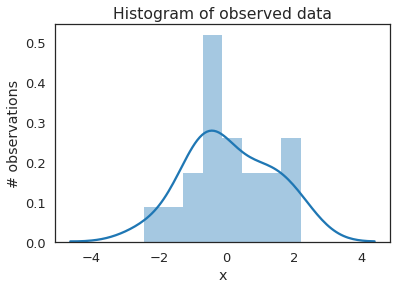

In [26]:
ax = plt.subplot()
sns.distplot(data, kde=True, ax=ax, bins=8)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

Next, we have to define our model. In this simple case, we will assume that this data is normal distributed, i.e. the likelihood of the model is normal. As you know, a normal distribution has two parameters -- mean $\mu$ and standard deviation $\sigma$. For simplicity, we'll assume we know that $\sigma = 1$ and we'll want to infer the posterior for $\mu$. For each parameter we want to infer, we have to chose a prior. For simplicity, lets also assume  a Normal distribution as a prior for $\mu$. Thus, in stats speak our model is:

$$\mu \sim \text{Normal}(0, 1)\\
x|\mu \sim \text{Normal}(x; \mu, 1)$$

What is convenient, is that for this model, we actually can compute the posterior analytically. That's because for a normal likelihood with known standard deviation, the normal prior for `mu` is [**conjugate**](https://en.wikipedia.org/wiki/Conjugate_prior) (conjugate here means that our posterior will follow the same distribution as the prior), so we know that our posterior for $\mu$ is also normal. We can easily look up on wikipedia how we can compute the parameters of the posterior. For a mathemtical derivation of this, see [here](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM).

In [27]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

In [29]:
sns.despine?

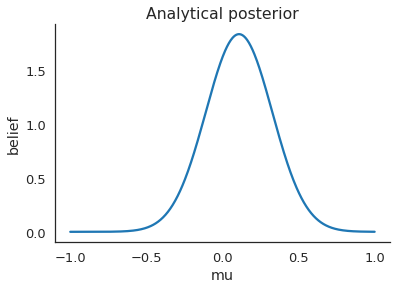

In [31]:
ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

This shows our quantity of interest, the probability of $\mu$'s values after having seen the data, taking our prior information into account. Lets assume, however, that our prior wasn't conjugate and we couldn't solve this by hand which is usually the case.

## Explaining MCMC sampling with code

Now on to the sampling logic. At first, you find starting parameter position (can be randomly chosen), lets fix it arbitrarily to:

```python
mu_current = 1.
```

Then, you propose to move (jump) from that position somewhere else (that's the Markov part). You can be very dumb or very sophisticated about how you come up with that proposal. The Metropolis sampler is very dumb and just takes a sample from a normal distribution (no relationship to the normal we assume for the model) centered around your current `mu` value (i.e. `mu_current`) with a certain standard deviation (`proposal_width`) that will determine how far you propose jumps (here we're use `scipy.stats.norm`):

```python
proposal = norm(mu_current, proposal_width).rvs()
```

Next, you evaluate whether that's a good place to jump to or not. If the resulting normal distribution with that proposed `mu` explaines the data better than your old `mu`, you'll definitely want to go there. What does "explains the data better" mean? We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed `mu` and a fixed `sigma = 1`). This can easily be computed by calculating the probability for each data point using `scipy.stats.normal(mu, sigma).pdf(data)` and then multiplying the individual probabilities, i.e. compute the likelihood (usually you would use log probabilities but we omit this here):

```python
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

```

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the `mu_proposal` has higher likelihood than `mu_current`. Eventually we'll get to `mu = 0` (or close to it) from where no more moves will be possible. However, we want to get a posterior so we'll also have to sometimes accept moves into the other direction. The key trick is by dividing the two probabilities,

```python
p_accept = p_proposal / p_current
```

we get an acceptance probability. You can already see that if `p_proposal` is larger, that probability will be `> 1` and we'll definitely accept. However, if `p_current` is larger, say twice as large, there'll be a 50% chance of moving there:

```python
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

```

This simple procedure gives us samples from the posterior.

### Why does this make sense?
Taking a step back, note that the above acceptance ratio is the reason this whole thing works out and we get around the integration. We can show this by computing the acceptance ratio over the normalized posterior and seeing how it's equivalent to the acceptance ratio of the unnormalized posterior (lets say $\mu_0$ is our current position, and $\mu$ is our proposal):

$$ \frac{\frac{P(x|\mu) P(\mu)}{P(x)}}{\frac{P(x|\mu_0) P(\mu_0)}{P(x)}} = \frac{P(x|\mu) P(\mu)}{P(x|\mu_0) P(\mu_0)}$$

In words, dividing the posterior of proposed parameter setting by the posterior of the current parameter setting, $P(x)$ -- that nasty quantity we can't compute -- gets canceled out. So you can intuit that we're actually dividing the full posterior at one position by the full posterior at another position (no magic here). That way, we are visiting regions of high posterior probability *relatively* more often than those of low posterior probability.

### Putting it all together

In [33]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

In [35]:
# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    plt.legend()

## Visualizing MCMC
To visualize the sampling, we'll create plots for some quantities that are computed. Each row below is a single iteration through our Metropolis sampler. 

The first columns is our prior distribution -- what our belief about $\mu$ is before seeing the data. You can see how the distribution is static and we only plug in our $\mu$ proposals. The vertical lines represent our current $\mu$ in blue and our proposed $\mu$ in either red or green (rejected or accepted, respectively). 

The 2nd column is our likelihood and what we are using to evaluate how good our model explains the data. You can see that the likelihood function changes in response to the proposed $\mu$. The blue histogram which is our data. The solid line in green or red is the likelihood with the currently proposed `mu`. Intuitively, the more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dotted line of the same color is the proposed `mu` and the dotted blue line is the current `mu`.

The 3rd column is our posterior distribution. Here I am displaying the normalized posterior but as we found out above, we can just multiply the prior value for the current and proposed $\mu$'s by the likelihood value for the two $\mu$'s to get the unnormalized posterior values (which we use for the actual computation), and divide one by the other to get our acceptance probability.

The 4th column is our trace (i.e. the posterior samples of $\mu$ we're generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that we always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values, as can be seen in iteration 14 (the iteration number can be found at the top center of each row).

/ihme/code/central_comp/new_miniconda/envs/gbd_env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


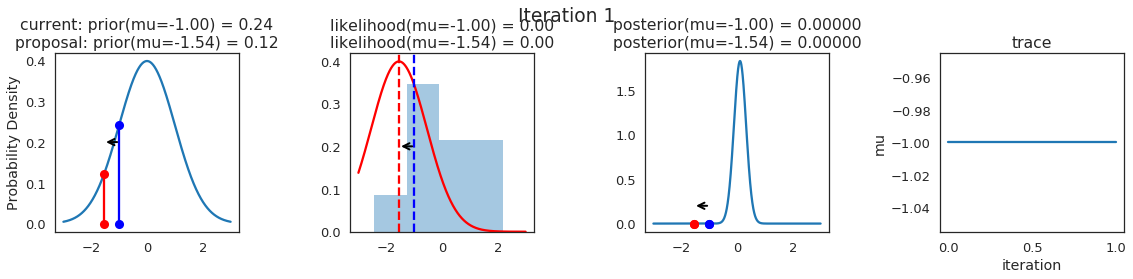

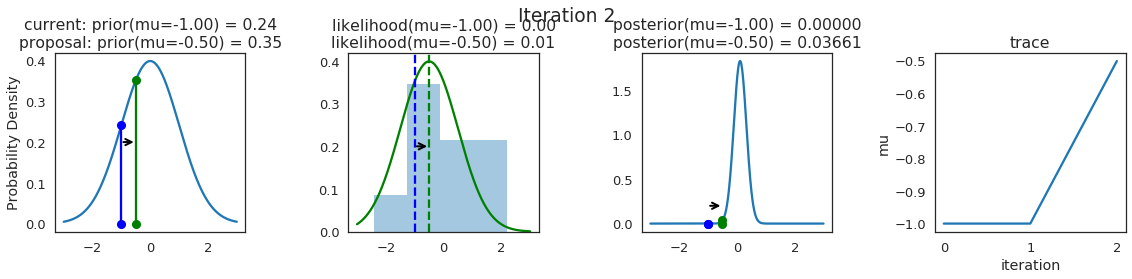

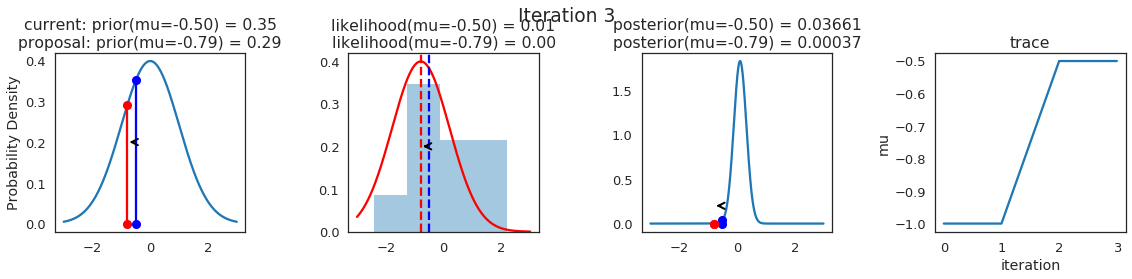

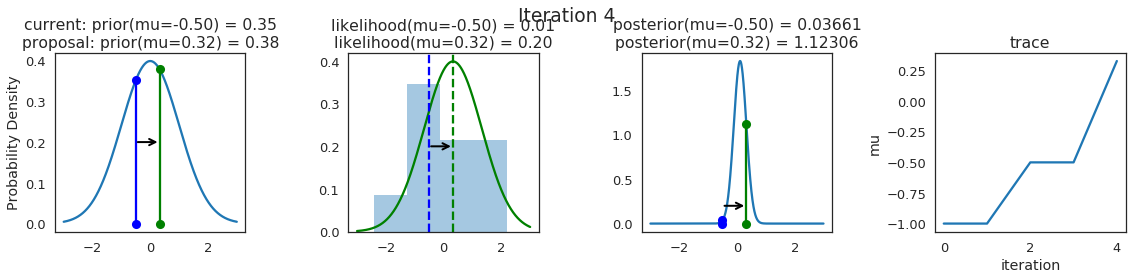

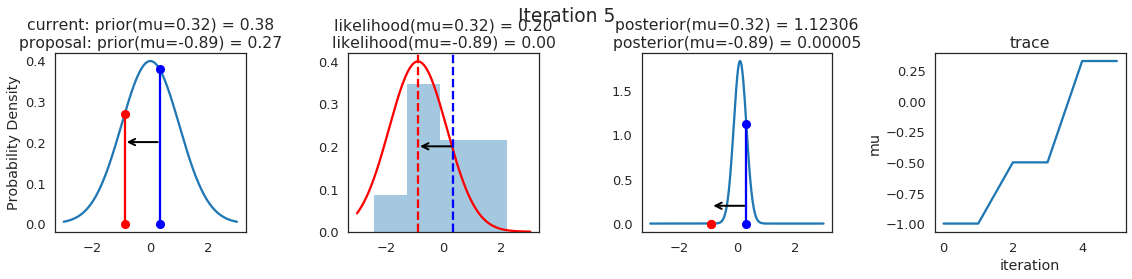

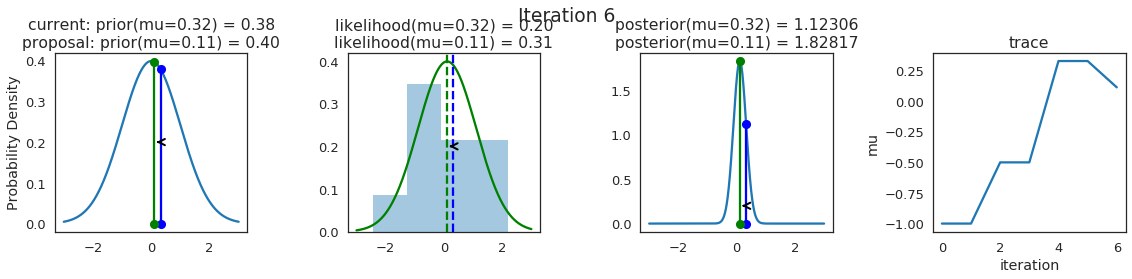

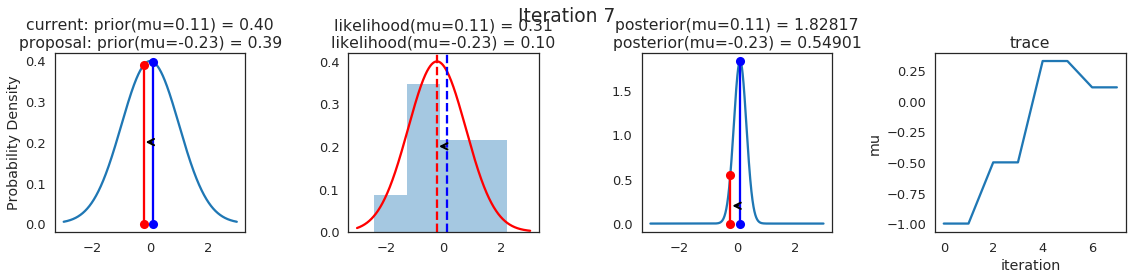

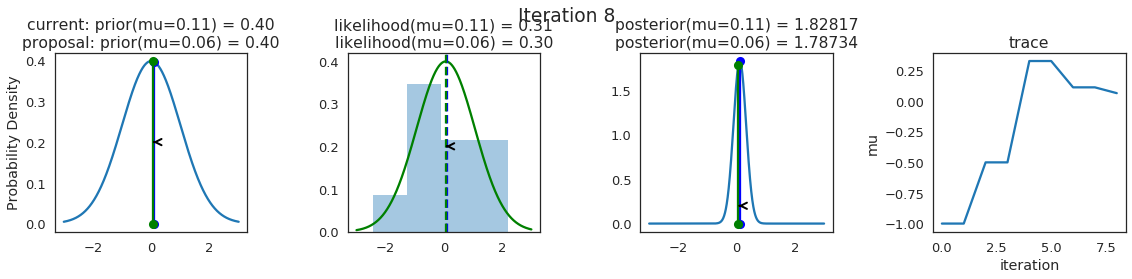

In [36]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

Now the magic of MCMC is that you just have to do that for a long time, and the samples that are generated in this way come from the posterior distribution of your model. There is a rigorous mathematical proof that guarantees this which I won't go into detail here.
To get a sense of what this produces, lets draw a lot of samples and plot them.

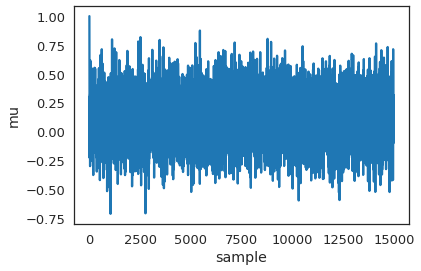

In [38]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

This is usually called the trace. To now get an approxmation of the posterior (the reason why we're doing all this), we simply take the histogram of this trace. It's important to keep in mind that although this looks similar to the data we sampled above to fit the model, the two are completely separate. The below plot represents our belief in mu. In this case it just happens to also be normal but for a different model, it could have a completely different shape than the likelihood or prior.

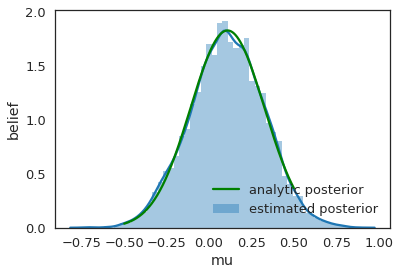

In [39]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

As you can see, by following the above procedure, we get samples from the same distribution as what we derived analytically.

## Proposal width

Above we set the proposal width to `0.5`. That turned out to be a pretty good value. In general you don't want the width to be too narrow because your sampling will be inefficient as it takes a long time to explore the whole parameter space and shows the typical random-walk behavior:

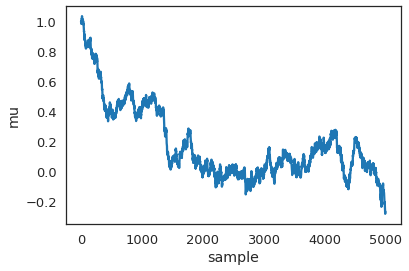

In [40]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

But you also don't want it to be so large that you never accept a jump:

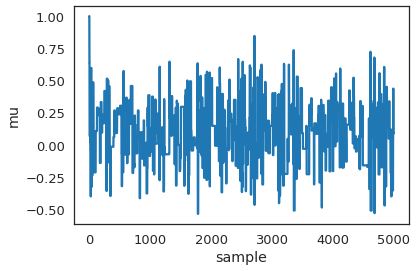

In [41]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

Note, however, that we are still sampling from our target posterior distribution here as guaranteed by the mathemtical proof, just less efficiently:

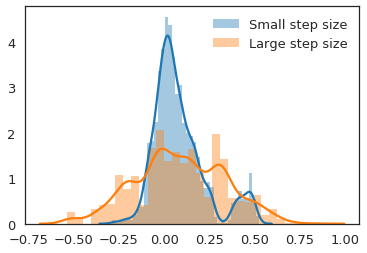

In [42]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

With more samples this will eventually look like the true posterior. The key is that we want our samples to be independent of each other which cleary isn't the case here. Thus, one common metric to evaluate the efficiency of our sampler is the autocorrelation -- i.e. how correlated a sample i is to sample i-1, i-2, etc:

In [43]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [autocorr(posterior_large, l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(posterior_small, l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(posterior, l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

ImportError: No module named pymc3.stats